In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, GridSearchCV 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer

In [2]:
# Make some room to see stuff (i.e. drop display limits on Pandas rows & cols - be careful w/ big df's!)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 1) Read in data & explore preliminarily

In [3]:
df = pd.read_csv('home_sales_dataset.csv')
print(df.shape)
df.head()

(1011, 18)


,sold_price,beds,baths,hm_sqft,lot_size,yr_built,zipcode,pool,garage,stories,schools,sold_date,address,days_on_mkt,hoa,url,lat,lon
0,970000,4,3.0,1933,6999,1960,91364,1,1,1,6.4,August-24-2021,22247 De La Osa St,3,0,http://www.redfin.com/CA/Woodland-Hills/22247-...,34.159168,-118.611596
1,900000,3,2.0,1519,11761,1974,91304,1,1,1,6.4,August-24-2021,7631 Atron Ave,3,0,http://www.redfin.com/CA/Canoga-Park/7631-Atro...,34.209223,-118.637737
2,830000,3,2.0,1595,10560,1960,91303,1,1,1,4.8,August-23-2021,22221 Vanowen St,4,0,http://www.redfin.com/CA/Canoga-Park/22221-Van...,34.193982,-118.611141
3,820000,3,2.5,1364,7253,1959,91307,0,0,1,7.0,August-23-2021,23433 Victory Blvd,4,0,http://www.redfin.com/CA/West-Hills/23433-Vict...,34.186740,-118.637805
4,940553,4,2.5,2018,9347,1960,91367,1,1,1,6.8,August-23-2021,23952 Oxnard St,4,0,http://www.redfin.com/CA/Woodland-Hills/23952-...,34.179507,-118.649017


In [4]:
df['sold_date'] = pd.to_datetime(df['sold_date'])

In [5]:
df.head()

,sold_price,beds,baths,hm_sqft,lot_size,yr_built,zipcode,pool,garage,stories,schools,sold_date,address,days_on_mkt,hoa,url,lat,lon
0,970000,4,3.0,1933,6999,1960,91364,1,1,1,6.4,2021-08-24,22247 De La Osa St,3,0,http://www.redfin.com/CA/Woodland-Hills/22247-...,34.159168,-118.611596
1,900000,3,2.0,1519,11761,1974,91304,1,1,1,6.4,2021-08-24,7631 Atron Ave,3,0,http://www.redfin.com/CA/Canoga-Park/7631-Atro...,34.209223,-118.637737
2,830000,3,2.0,1595,10560,1960,91303,1,1,1,4.8,2021-08-23,22221 Vanowen St,4,0,http://www.redfin.com/CA/Canoga-Park/22221-Van...,34.193982,-118.611141
3,820000,3,2.5,1364,7253,1959,91307,0,0,1,7.0,2021-08-23,23433 Victory Blvd,4,0,http://www.redfin.com/CA/West-Hills/23433-Vict...,34.186740,-118.637805
4,940553,4,2.5,2018,9347,1960,91367,1,1,1,6.8,2021-08-23,23952 Oxnard St,4,0,http://www.redfin.com/CA/Woodland-Hills/23952-...,34.179507,-118.649017


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011 entries, 0 to 1010
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   sold_price   1011 non-null   int64         
 1   beds         1011 non-null   int64         
 2   baths        1011 non-null   float64       
 3   hm_sqft      1011 non-null   int64         
 4   lot_size     1011 non-null   int64         
 5   yr_built     1011 non-null   int64         
 6   zipcode      1011 non-null   int64         
 7   pool         1011 non-null   int64         
 8   garage       1011 non-null   int64         
 9   stories      1011 non-null   int64         
 10  schools      1011 non-null   float64       
 11  sold_date    1011 non-null   datetime64[ns]
 12  address      1011 non-null   object        
 13  days_on_mkt  1011 non-null   int64         
 14  hoa          1011 non-null   int64         
 15  url          1011 non-null   object        
 16  lat   

In [7]:
df.drop(columns=['zipcode', 'lat', 'lon']).describe()

,sold_price,beds,baths,hm_sqft,lot_size,yr_built,pool,garage,stories,schools,days_on_mkt,hoa
count,1.011000e+03,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000
mean,1.126206e+06,3.633037,2.544510,2081.720079,10828.724036,1960.297725,0.134520,0.140455,1.178042,5.738731,44.678536,2.430267
std,5.022851e+05,0.844819,0.924634,886.574023,15533.545033,11.616964,0.341379,0.347630,0.387876,0.674897,24.281487,24.731666
min,4.000000e+05,1.000000,1.000000,552.000000,2000.000000,1920.000000,0.000000,0.000000,1.000000,4.200000,1.000000,0.000000
25%,8.400000e+05,3.000000,2.000000,1471.000000,7083.000000,1954.000000,0.000000,0.000000,1.000000,5.200000,25.000000,0.000000
50%,9.650000e+05,4.000000,2.000000,1873.000000,8217.000000,1958.000000,0.000000,0.000000,1.000000,5.666667,44.000000,0.000000
75%,1.260000e+06,4.000000,3.000000,2447.000000,11761.000000,1964.000000,0.000000,0.000000,1.000000,6.166667,64.000000,0.000000
max,5.500000e+06,8.000000,8.000000,8189.000000,475675.000000,2021.000000,1.000000,1.000000,3.000000,7.666667,90.000000,585.000000


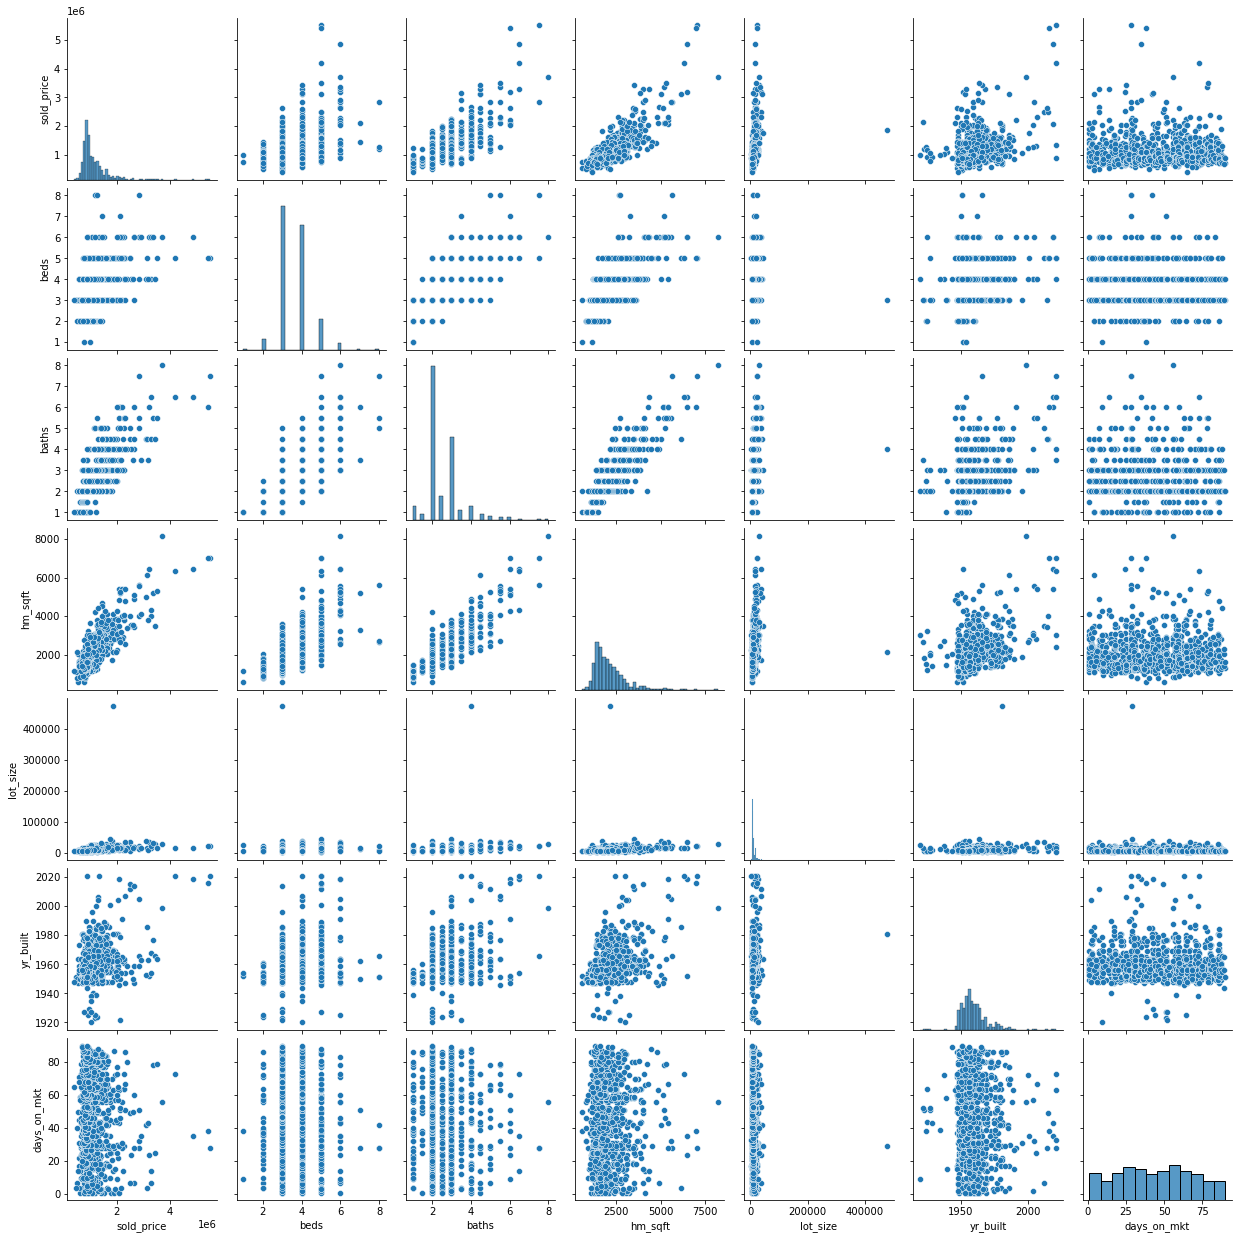

In [8]:
sns.pairplot(data = df, 
             vars = ['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built', 'days_on_mkt']);

#### Drop that one home with a huge lot_size from the dataset (obvious undesirable outlier, not representative of vast majority)

In [9]:
print(df.shape)
df = df[df['lot_size'] < 200000]
df.reset_index(drop=True, inplace=True)
print(df.shape)

(1011, 18)
(1010, 18)


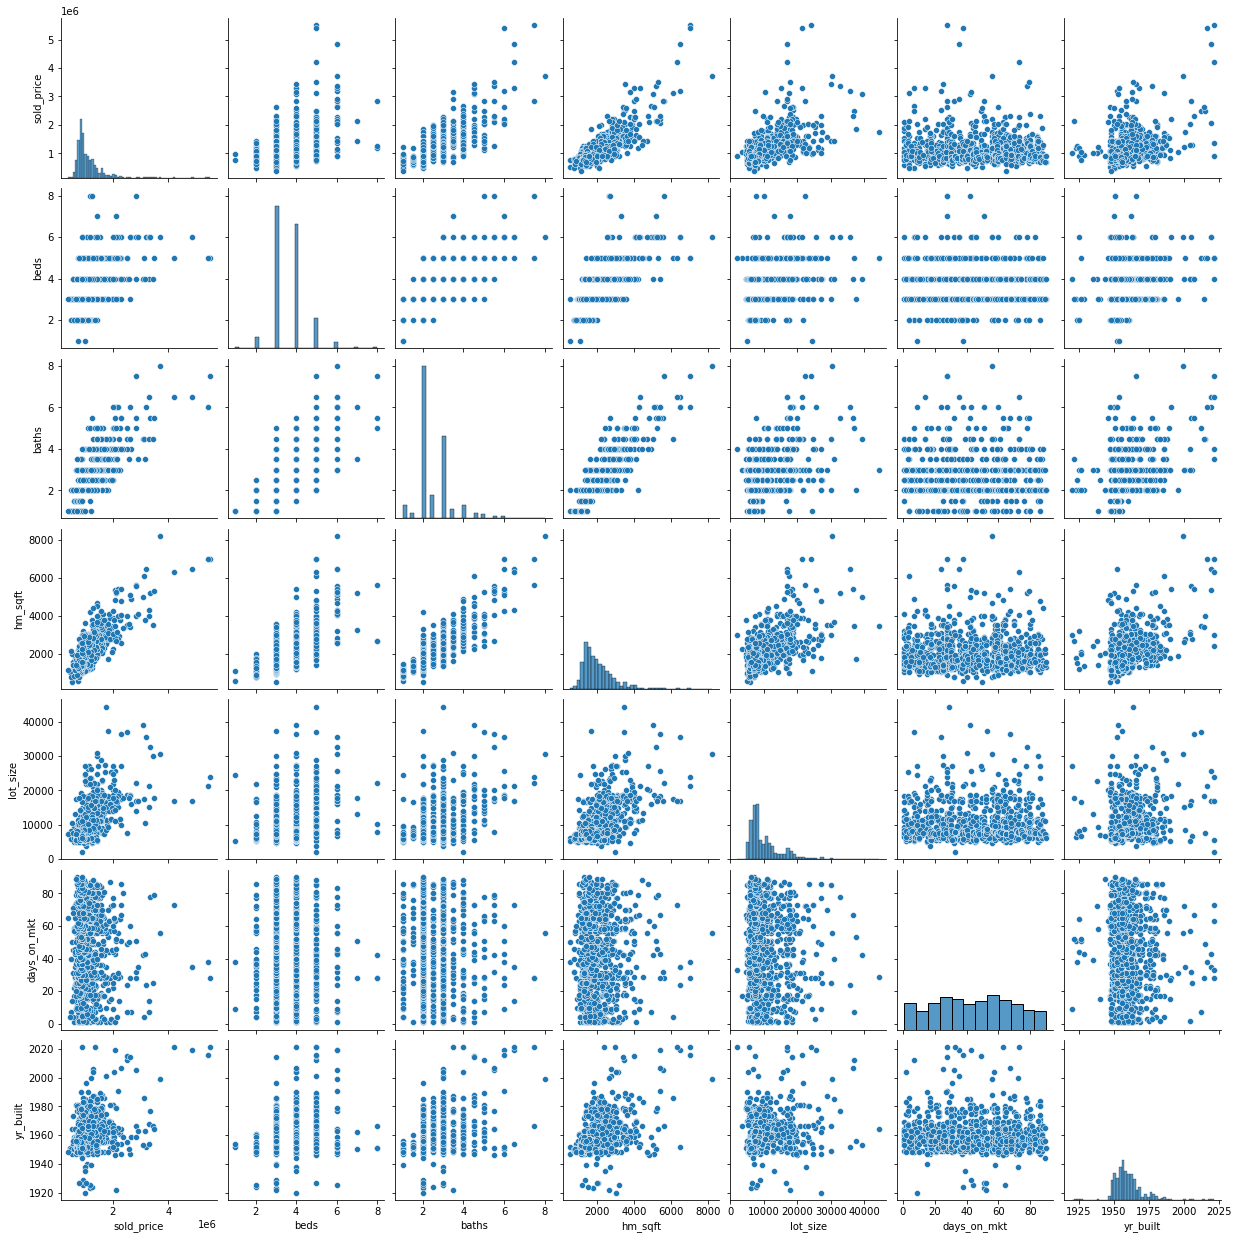

In [10]:
sns.pairplot(data = df, 
             vars = ['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'days_on_mkt', 'yr_built']);

In [11]:
df[['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built', 'days_on_mkt']].corr()

,sold_price,beds,baths,hm_sqft,lot_size,yr_built,days_on_mkt
sold_price,1.000000,0.468586,0.747992,0.836873,0.616309,0.405557,-0.015035
beds,0.468586,1.000000,0.677780,0.673701,0.353676,0.330157,-0.003969
baths,0.747992,0.677780,1.000000,0.853740,0.506800,0.425517,-0.003983
hm_sqft,0.836873,0.673701,0.853740,1.000000,0.611860,0.482993,-0.012386
lot_size,0.616309,0.353676,0.506800,0.611860,1.000000,0.235796,-0.011387
yr_built,0.405557,0.330157,0.425517,0.482993,0.235796,1.000000,-0.031676
days_on_mkt,-0.015035,-0.003969,-0.003983,-0.012386,-0.011387,-0.031676,1.000000


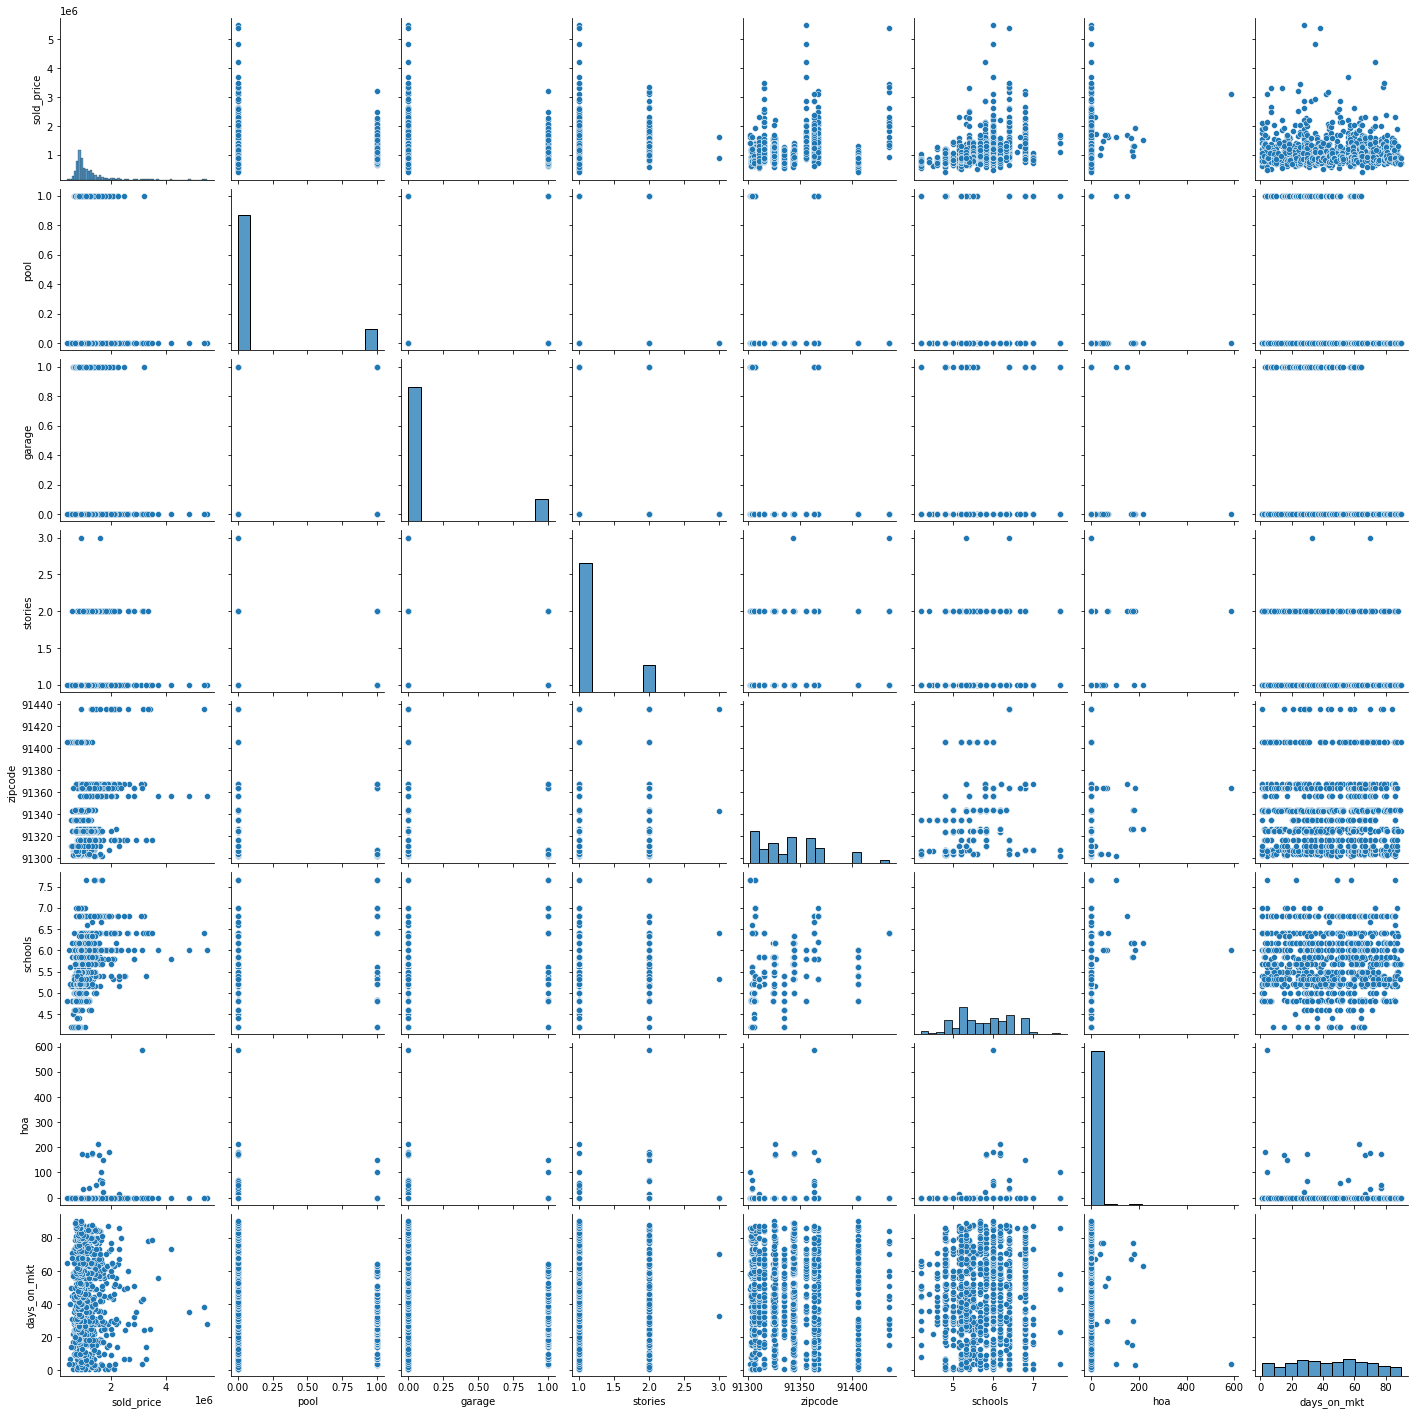

In [12]:
sns.pairplot(data = df, 
             vars = ['sold_price', 'pool', 'garage', 'stories', 'zipcode', 'schools', 'hoa', 'days_on_mkt']);

In [13]:
df[['sold_price', 'pool', 'garage', 'stories', 'zipcode', 'schools', 'hoa', 'days_on_mkt']].corr()

,sold_price,pool,garage,stories,zipcode,schools,hoa,days_on_mkt
sold_price,1.000000,0.028298,0.025144,0.187080,0.219329,0.356463,0.143552,-0.015035
pool,0.028298,1.000000,0.950247,0.074175,-0.100235,0.268048,-0.009247,-0.219170
garage,0.025144,0.950247,1.000000,0.057655,-0.096038,0.280840,-0.010762,-0.225222
stories,0.187080,0.074175,0.057655,1.000000,-0.028739,0.177494,0.136809,-0.051873
zipcode,0.219329,-0.100235,-0.096038,-0.028739,1.000000,0.267983,0.006319,-0.012574
schools,0.356463,0.268048,0.280840,0.177494,0.267983,1.000000,0.061756,-0.026134
hoa,0.143552,-0.009247,-0.010762,0.136809,0.006319,0.061756,1.000000,-0.042238
days_on_mkt,-0.015035,-0.219170,-0.225222,-0.051873,-0.012574,-0.026134,-0.042238,1.000000


#### Early conclusion: days_on_mkt (and alternative target) is uniformly distributed & pretty much uncorrelated w/ everything else!

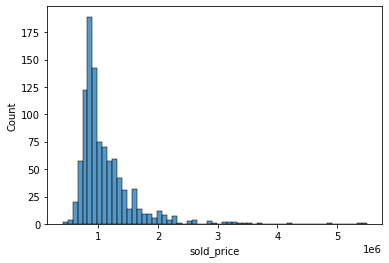

In [14]:
sns.histplot(data=df['sold_price']);

#### Perhaps log transforming the target can lead to a better model

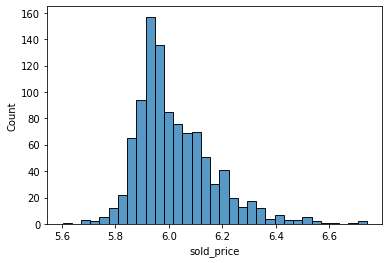

In [16]:
sns.histplot(data=np.log10(df['sold_price']));

# 2) Feature Engineering (part 1)

### Start with appropriate one-hot encoding: zipcode

In [17]:
df_data = pd.get_dummies(data=df[['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built', 
                                  'pool', 'garage', 'stories', 'zipcode', 'schools', 'hoa']], 
                         columns=['zipcode'], 
                         drop_first=True)

### Change 'stories' to binary variable 'one_story' (1 = yes, 0 = no => multi-story)

In [18]:
df_data['stories'].value_counts()

1    833
2    175
3      2
Name: stories, dtype: int64

In [19]:
df_data.loc[df_data['stories'] > 1, 'stories'] = 0
df_data.rename(columns={'stories': 'one_story'}, inplace=True)
df_data.head()

,sold_price,beds,baths,hm_sqft,lot_size,yr_built,pool,garage,one_story,schools,hoa,zipcode_91303,zipcode_91304,zipcode_91306,zipcode_91307,zipcode_91311,zipcode_91316,zipcode_91324,zipcode_91325,zipcode_91326,zipcode_91335,zipcode_91343,zipcode_91344,zipcode_91356,zipcode_91364,zipcode_91367,zipcode_91406,zipcode_91436
0,970000,4,3.0,1933,6999,1960,1,1,1,6.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,900000,3,2.0,1519,11761,1974,1,1,1,6.4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,830000,3,2.0,1595,10560,1960,1,1,1,4.8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,820000,3,2.5,1364,7253,1959,0,0,1,7.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,940553,4,2.5,2018,9347,1960,1,1,1,6.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [20]:
df_data['one_story'].value_counts()

1    833
0    177
Name: one_story, dtype: int64

# 3) Baseline Features for Modeling

#### Define a Diagnostic Plot Function 
##### (adapted from func of same name provided in Metis linear assumptions & testing notebook)

In [21]:
def diagnostic_plots(x, y, y_pred):    
    
#     print('RMSE: {}'.format(round(mean_squared_error(y, y_pred, squared=False), 3)))
#     print('MAE: {}'.format(round(mean_absolute_error(y, y_pred), 3)))
    
    plt.figure(figsize=(20,5))
    plt.subplot(1, 3, 1)
    plt.scatter(y_pred,y)
    plt.title("Predicted vs. Actual Sale Price")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    plt.subplot(1, 3, 2)
    res = y - y_pred
    plt.scatter(y_pred, res)
    plt.axhline(y=0.0, color='r', linestyle='-')
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

In [22]:
def cv_rsquareds(x, y, model, cv):    
    scores = cross_val_score(model, x, y, scoring='r2', cv=cv)
    scores = [round(val, 3) for val in scores]
    
    print('CV R-squareds: {}'.format(scores)) 
    print('Mean CV R-squared: {} +/- {}'.format(round(np.mean(scores), 3), round(np.std(scores), 3)))
    
    n = x.shape[0]
    p = x.shape[1]
    adj_r_squareds = [round(1 - (1 - r_squared)*((n - 1)/(n - p - 1)), 3) for r_squared in scores]
    print('\nAdjusted CV R-squareds: {}'.format(adj_r_squareds))
    print('Mean Adjusted CV R-squared: {} +/- {}'.format(round(np.mean(adj_r_squareds), 3), 
                                                         round(np.std(adj_r_squareds), 3)))

In [23]:
# This function inverts the log transform on y_pred and y prior so that MAE can be computed in dollars

def mae_for_log_y(y, y_pred):
    return mean_absolute_error(10**y, 10**y_pred)

scorer = make_scorer(mae_for_log_y, greater_is_better=False)

In [28]:
def cv_maes(x, y, model, cv):
    scores = cross_val_score(model, x, y, scoring=scorer, cv=cv)
    scores = [round(val) for val in scores]
    
    print('\nCV MAEs: {}'.format([-1*score for score in scores])) 
    print('Mean CV MAE: {} +/- {}'.format(-1*round(np.mean(scores)), round(np.std(scores))))

### Split into CV and Test Sets (will NOT touch Test set until final model has been chosen and tuned!)

#### This time, let's make log('sold_price') the target

In [25]:
X = df_data.drop(columns='sold_price')
y = np.log10(df_data['sold_price'])

In [26]:
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Baseline Model 1: Linear Model, all features

In [29]:
model_1 = LinearRegression()

cv_rsquareds(X_cv, y_cv, model_1, 5)
cv_maes(X_cv, y_cv, model_1, 5)

CV R-squareds: [0.82, 0.827, 0.837, 0.85, 0.846]
Mean CV R-squared: 0.836 +/- 0.011

Adjusted CV R-squareds: [0.814, 0.821, 0.831, 0.845, 0.841]
Mean Adjusted CV R-squared: 0.83 +/- 0.012

CV MAEs: [156099, 118696, 118838, 124854, 113542]
Mean CV MAE: 126406 +/- 15273


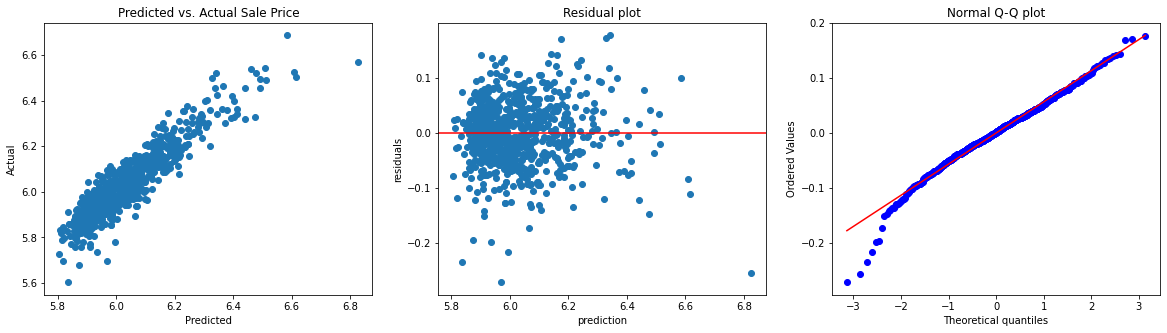

In [30]:
model_1.fit(X_cv, y_cv)

y_pred = model_1.predict(X_cv)

diagnostic_plots(X_cv, y_cv, y_pred)

#### Are the two highest priced predictions  influential points? Let's refit this using statsmodels to find out:

In [98]:
x_cv = sm.add_constant(X_cv)
model = sm.OLS(y_cv, x_cv)
model_1b = model.fit()
model_1b.summary()

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sold_price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     163.5
Date:                Sat, 04 Sep 2021   Prob (F-statistic):          1.55e-299
Time:                        23:55:00   Log-Likelihood:                 1167.4
No. Observations:                 808   AIC:                            -2279.
Df Residuals:                     780   BIC:                            -2147.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.2724      0.436     12.088      0.000       4.416       6.129
beds             -0.0015      0.004     -0.409      0.683      -0.009       0.006
baths             0.0242      0.005      5.348      0.000       0.015       0.033
hm_sqft        7.609e-05    5.4e-06     14.087      0.000    6.55e-05    8.67e-05
lot_size       5.619e-06   5.37e-07     10.462      0.000    4.56e-06    6.67e-06
yr_built          0.0002      0.000      0.799      0.425      -0.000       0.001
pool             -0.0043      0.020     -0.213      0.832      -0.044       0.035
garage            0.0016      0.020      0.081      0.935      -0.037       0.041
one_story         0.0177      0.006      2.811      0.005       0.005       0.030
schools           0.0345      0.005      6.736      0.000       0.024       0.045
hoa            7.928e-05   7.78e-05      1.019      0.308   -7.34e-05       0.000
zipcode_91303    -0.0884      0.035     -2.492      0.013      -0.158      -0.019
zipcode_91304    -0.0993      0.032     -3.080      0.002      -0.163      -0.036
zipcode_91306    -0.1205      0.034     -3.501      0.000      -0.188      -0.053
zipcode_91307    -0.1191      0.031     -3.835      0.000      -0.180      -0.058
zipcode_91311    -0.1412      0.033     -4.230      0.000      -0.207      -0.076
zipcode_91316     0.0198      0.032      0.614      0.539      -0.044       0.083
zipcode_91324    -0.0974      0.034     -2.869      0.004      -0.164      -0.031
zipcode_91325    -0.1163      0.033     -3.578      0.000      -0.180      -0.053
zipcode_91326    -0.0957      0.031     -3.049      0.002      -0.157      -0.034
zipcode_91335    -0.0972      0.033     -2.914      0.004      -0.163      -0.032
zipcode_91343    -0.1346      0.032     -4.200      0.000      -0.197      -0.072
zipcode_91344    -0.1206      0.031     -3.842      0.000      -0.182      -0.059
zipcode_91356    -0.0080      0.033     -0.244      0.807      -0.072       0.056
zipcode_91364    -0.0521      0.031     -1.701      0.089      -0.112       0.008
zipcode_91367    -0.0646      0.030     -2.120      0.034      -0.124      -0.005
zipcode_91406    -0.1140      0.032     -3.544      0.000      -0.177      -0.051
zipcode_91436     0.0591      0.034      1.759      0.079      -0.007       0.125
==============================================================================
Omnibus:                       57.542   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              117.893
Skew:                          -0.445   Prob(JB):                     2.51e-26
Kurtosis:                       4.646   Cond. No.                     2.56e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of th

In [107]:
influence_frame = model_1b.get_influence().summary_frame()
influence_frame['cooks_d'].sort_values(ascending=False).head()

499    0.104216
695    0.028743
715    0.017149
743    0.016793
129    0.016564
Name: cooks_d, dtype: float64

##### Technically, no influence points (Cook's dist > 0.5), but as suspected, largest Cook's distances are all for sale prices > 3e6

In [108]:
print(y_cv.loc[468])
print(y_cv.loc[413])
print(y_cv.loc[695])
print(y_cv.loc[692])

6.685741738602264
6.494850021680094
6.49996186559619
6.537189226243645


In [109]:
df_data[df_data['sold_price'] >= 3e6].shape[0]

14

In [110]:
df_data['sold_price'].describe()

count    1.010000e+03
mean     1.125490e+06
std      5.020166e+05
min      4.000000e+05
25%      8.400000e+05
50%      9.650000e+05
75%      1.260000e+06
max      5.500000e+06
Name: sold_price, dtype: float64

In [111]:
df_data[df_data['sold_price'] <= 3e6]['sold_price'].describe()

count    9.960000e+02
mean     1.087947e+06
std      3.799263e+05
min      4.000000e+05
25%      8.387500e+05
50%      9.600000e+05
75%      1.250000e+06
max      2.919500e+06
Name: sold_price, dtype: float64

#### While we're here, what about colinearity (VIF)?

In [112]:
variables = model_1b.model.exog

# Don't count the intercept! (index=0)
vifs = [variance_inflation_factor(variables, i) for i in range(1, variables.shape[1])]
list(zip(X_cv.columns, vifs))

[('beds', 2.3748583643981656),
 ('baths', 4.072735302379183),
 ('hm_sqft', 5.437264869722127),
 ('lot_size', 1.8733264817992954),
 ('yr_built', 1.5700897667828313),
 ('pool', 11.57502382688967),
 ('garage', 11.747185650226495),
 ('one_story', 1.3833790612343233),
 ('schools', 2.8474981567584066),
 ('hoa', 1.099961309515748),
 ('zipcode_91303', 6.572944824369663),
 ('zipcode_91304', 17.114664326885844),
 ('zipcode_91306', 9.160317438887061),
 ('zipcode_91307', 14.155094527004882),
 ('zipcode_91311', 9.843143469181072),
 ('zipcode_91316', 12.274967108237547),
 ('zipcode_91324', 6.336828564376861),
 ('zipcode_91325', 10.78526152242736),
 ('zipcode_91326', 13.688698052439177),
 ('zipcode_91335', 14.904258380835545),
 ('zipcode_91343', 14.012337965465685),
 ('zipcode_91344', 23.14157781344486),
 ('zipcode_91356', 9.990088245643582),
 ('zipcode_91364', 22.477096197707578),
 ('zipcode_91367', 19.83941218634806),
 ('zipcode_91406', 17.56390245617648),
 ('zipcode_91436', 5.248328562896553)]

In [113]:
X_cv[['pool', 'garage']].corr()

,pool,garage
pool,1.000000,0.954522
garage,0.954522,1.000000


In [114]:
X_cv[['pool', 'garage']].value_counts()

pool  garage
0     0         689
1     1         110
0     1           7
1     0           2
dtype: int64

#### Aha! 'pool' & 'garage' are highly correlated (missed that in the pair plots); let's drop 'pool'

In [115]:
X_cv = X_cv.drop(columns='pool')

#### Now, is there anything we can do about the high VIFs of the zipcode one-hots?

In [116]:
df['zipcode'].value_counts()

91364    120
91344    107
91367     96
91304     75
91406     72
91307     66
91326     65
91343     65
91335     59
91316     53
91356     45
91325     43
91306     40
91311     38
91324     22
91303     21
91436     19
91302      4
Name: zipcode, dtype: int64

In [117]:
X_cv[['zipcode_91303', 'zipcode_91304', 'zipcode_91306', 'zipcode_91307', 
     'zipcode_91311', 'zipcode_91316', 'zipcode_91324', 'zipcode_91325', 
     'zipcode_91326', 'zipcode_91335', 'zipcode_91343', 'zipcode_91344', 
     'zipcode_91356', 'zipcode_91364', 'zipcode_91367', 'zipcode_91406', 'zipcode_91436']].corr()

,zipcode_91303,zipcode_91304,zipcode_91306,zipcode_91307,zipcode_91311,zipcode_91316,zipcode_91324,zipcode_91325,zipcode_91326,zipcode_91335,zipcode_91343,zipcode_91344,zipcode_91356,zipcode_91364,zipcode_91367,zipcode_91406,zipcode_91436
zipcode_91303,1.000000,-0.042751,-0.028066,-0.039993,-0.030150,-0.035345,-0.023424,-0.032596,-0.038768,-0.037935,-0.038353,-0.053107,-0.031148,-0.053775,-0.050038,-0.043516,-0.021455
zipcode_91304,-0.042751,1.000000,-0.052660,-0.075039,-0.056571,-0.066319,-0.043950,-0.061160,-0.072740,-0.071177,-0.071962,-0.099645,-0.058443,-0.100899,-0.093887,-0.081649,-0.040255
zipcode_91306,-0.028066,-0.052660,1.000000,-0.049263,-0.037139,-0.043538,-0.028853,-0.040151,-0.047754,-0.046727,-0.047243,-0.065416,-0.038367,-0.066240,-0.061636,-0.053602,-0.026427
zipcode_91307,-0.039993,-0.075039,-0.049263,1.000000,-0.052922,-0.062040,-0.041115,-0.057215,-0.068048,-0.066585,-0.067320,-0.093217,-0.054673,-0.094390,-0.087830,-0.076382,-0.037658
zipcode_91311,-0.030150,-0.056571,-0.037139,-0.052922,1.000000,-0.046771,-0.030996,-0.043133,-0.051300,-0.050198,-0.050751,-0.070275,-0.041217,-0.071159,-0.066214,-0.057583,-0.028390
zipcode_91316,-0.035345,-0.066319,-0.043538,-0.062040,-0.046771,1.000000,-0.036337,-0.050565,-0.060140,-0.058847,-0.059496,-0.082384,-0.048319,-0.083420,-0.077623,-0.067505,-0.033282
zipcode_91324,-0.023424,-0.043950,-0.028853,-0.041115,-0.030996,-0.036337,1.000000,-0.033510,-0.039856,-0.038999,-0.039429,-0.054597,-0.032022,-0.055284,-0.051442,-0.044737,-0.022056
zipcode_91325,-0.032596,-0.061160,-0.040151,-0.057215,-0.043133,-0.050565,-0.033510,1.000000,-0.055462,-0.054270,-0.054868,-0.075975,-0.044560,-0.076931,-0.071585,-0.062254,-0.030693
zipcode_91326,-0.038768,-0.072740,-0.047754,-0.068048,-0.051300,-0.060140,-0.039856,-0.055462,1.000000,-0.064545,-0.065257,-0.090361,-0.052998,-0.091498,-0.085139,-0.074042,-0.036505
zipcode_91335,-0.037935,-0.071177,-0.046727,-0.066585,-0.050198,-0.058847,-0.038999,-0.054270,-0.064545,1.000000,-0.063854,-0.088419,-0.051858,-0.089531,-0.083309,-0.072450,-0.035720


#### Not any obvious correlations above; are these zipcode VIFs really a concern? Will leave this alone for now.

##### Command decision: 'sold_price' >= 3 million is almost 4-sigma from the mean, so let's just drop the 14 >= 3 million dollar homes
##### (i.e. This model is geared towards the much more common lower home prices, not the handful of very high-priced homes)

In [118]:
X = df_data[df_data['sold_price'] <= 3e6].drop(columns='sold_price')
y = df_data[df_data['sold_price'] <= 3e6]['sold_price']
y = np.log10(y)

X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [119]:
model_1c = LinearRegression()

cv_rsquareds(X_cv, y_cv, model_1c, 5)
cv_maes(X_cv, y_cv, model_1c, 5)

CV R-squareds: [0.86, 0.813, 0.79, 0.789, 0.741]
Mean CV R-squared: 0.799 +/- 0.039

Adjusted CV R-squareds: [0.855, 0.806, 0.783, 0.782, 0.732]
Mean Adjusted CV R-squared: 0.792 +/- 0.04

CV MAEs: [0.046006876934854064, 0.044550790469233686, 0.04749391660289024, 0.04121298095509291, 0.047194880540625955]
Mean CV MAE: 0.04529188910053937 +/- 0.002287716240519487


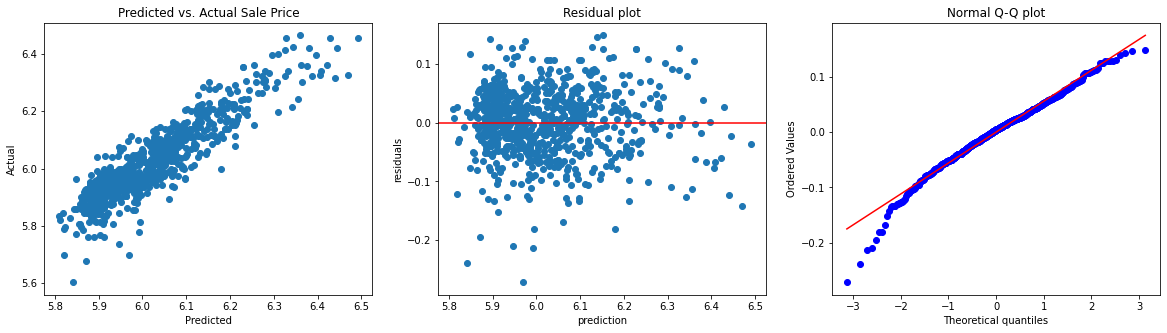

In [120]:
model_1c.fit(X_cv, y_cv)

y_pred = model_1c.predict(X_cv)

diagnostic_plots(X_cv, y_cv, y_pred)

### Model 2: Try adding some further features

#### 'beds', 'baths', 'hm_sqft', 'schools' all show signs of a possible 2nd-order relationship w/ 'sold_price'

In [121]:
df_data['beds_SQ'] = df_data['beds'] * df_data['beds']
df_data['baths_SQ'] = df_data['baths'] * df_data['baths']
df_data['hm_sqft_SQ'] = df_data['hm_sqft'] * df_data['hm_sqft']
df_data['lot_size_SQ'] = df_data['lot_size'] * df_data['lot_size']
df_data['schools_SQ'] = df_data['schools'] * df_data['schools']
df_data['yr_built_SQ'] = df_data['yr_built'] * df_data['yr_built']

In [122]:
X2 = df_data[df_data['sold_price'] <= 3e6].drop(columns='sold_price')

X2_cv, X2_test, y2_cv, y2_test = train_test_split(X2, y, test_size=0.2, random_state=42)

In [123]:
model_2 = LinearRegression()

cv_rsquareds(X2_cv, y2_cv, model_2, 5)
cv_maes(X2_cv, y2_cv, model_2, 5)

CV R-squareds: [0.87, 0.825, 0.794, 0.795, 0.745]
Mean CV R-squared: 0.806 +/- 0.041

Adjusted CV R-squareds: [0.864, 0.817, 0.785, 0.786, 0.734]
Mean Adjusted CV R-squared: 0.797 +/- 0.043

CV MAEs: [0.044383398929254005, 0.04266362393155192, 0.04623871515040892, 0.04002524107191878, 0.04586425145710856]
Mean CV MAE: 0.04383504610804844 +/- 0.0022839804885019153


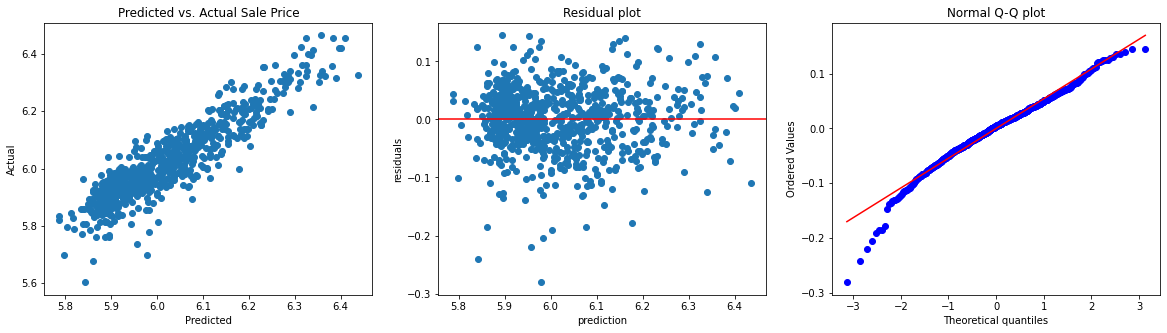

In [124]:
model_2.fit(X2_cv, y2_cv)

y2_pred = model_2.predict(X2_cv)

diagnostic_plots(X2_cv, y2_cv, y2_pred)

In [125]:
list(zip(X2_cv.columns, model_2.coef_))

[('beds', 0.013437387787109652),
 ('baths', 0.024071945452066788),
 ('hm_sqft', 0.00010932648975888411),
 ('lot_size', 1.2131462274465006e-05),
 ('yr_built', 0.001086695463465106),
 ('pool', -0.01536263107958871),
 ('garage', 0.013622866762194184),
 ('one_story', 0.013984652769950413),
 ('schools', -0.04196198840922352),
 ('hoa', 7.964126437355373e-05),
 ('zipcode_91303', -0.09730434395756288),
 ('zipcode_91304', -0.10708747744975733),
 ('zipcode_91306', -0.12874432305226846),
 ('zipcode_91307', -0.12272462404299304),
 ('zipcode_91311', -0.13338717882610787),
 ('zipcode_91316', 0.026039822021457777),
 ('zipcode_91324', -0.10168058600880771),
 ('zipcode_91325', -0.11716761933268757),
 ('zipcode_91326', -0.10026498480980969),
 ('zipcode_91335', -0.09081194852700838),
 ('zipcode_91343', -0.1398851228965712),
 ('zipcode_91344', -0.12047686143076847),
 ('zipcode_91356', -0.019979333374951922),
 ('zipcode_91364', -0.05231329207060248),
 ('zipcode_91367', -0.0621836700129464),
 ('zipcode_9140

### Model 3: Try "Lazy" Lasso (specifically to eliminate some predictors)

In [126]:
X3 = df_data[df_data['sold_price'] <= 3e6].drop(columns='sold_price')

X3_cv, X3_test, y3_cv, y3_test = train_test_split(X3, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X3_cv_scaled = scaler.fit_transform(X3_cv)

In [127]:
alphas = 10**np.linspace(-4, 4, 1000)
lasso_model = LassoCV(alphas=alphas, cv=5, normalize=False, max_iter=100000)

lasso_model.fit(X3_cv_scaled, y3_cv)

alpha = round(lasso_model.alpha_, 2)
print('Best alpha: {}'.format(alpha))

Best alpha: 0.0


In [128]:
model_3 = Lasso(alpha=0, max_iter=100000)

cv_rsquareds(X3_cv_scaled, y3_cv, model_3, 5)
cv_maes(X3_cv_scaled, y3_cv, model_3, 5)

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9597668137180407, tolerance: 0.001044835226496121
  model = cd_fast.enet_coordinate_descent(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: 

CV R-squareds: [0.87, 0.826, 0.794, 0.795, 0.745]
Mean CV R-squared: 0.806 +/- 0.041

Adjusted CV R-squareds: [0.864, 0.818, 0.785, 0.786, 0.734]
Mean Adjusted CV R-squared: 0.797 +/- 0.043


/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9597668137180407, tolerance: 0.001044835226496121
  model = cd_fast.enet_coordinate_descent(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:


CV MAEs: [0.04437265546726778, 0.04260572624896109, 0.04623875858095727, 0.04002519571842465, 0.04586153183818575]
Mean CV MAE: 0.04382077357075931 +/- 0.002289046555692897


/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9141742830016268, tolerance: 0.0012027616955782808
  model = cd_fast.enet_coordinate_descent(


/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_37502/4289867821.py:1: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model_3.fit(X3_cv_scaled, y3_cv)
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.19431312214053, tolerance: 0.0014422680230034325
  model = cd_fast.enet_coordinate_descent(


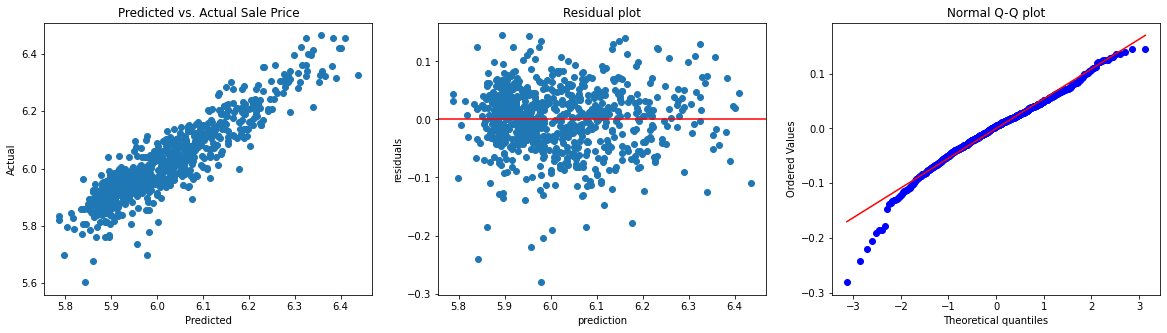

In [129]:
model_3.fit(X3_cv_scaled, y3_cv)

y3_pred = model_3.predict(X3_cv_scaled)

diagnostic_plots(X3_cv, y3_cv, y3_pred)

#### On a Mean MAE basis, this is on par w/ Model 2

In [130]:
list(zip(X3_cv.columns, model_3.coef_))

[('beds', 0.011257438812474707),
 ('baths', 0.020499422168533663),
 ('hm_sqft', 0.08613361164389954),
 ('lot_size', 0.06155805011341172),
 ('yr_built', 0.011498770857328458),
 ('pool', -0.005302663344629366),
 ('garage', 0.004790061032996192),
 ('one_story', 0.005278711799929212),
 ('schools', -0.028208855313259278),
 ('hoa', 0.001301484838866571),
 ('zipcode_91303', -0.01365626901734648),
 ('zipcode_91304', -0.02848626272796947),
 ('zipcode_91306', -0.026033559341327384),
 ('zipcode_91307', -0.0316431926627598),
 ('zipcode_91311', -0.024573265149752645),
 ('zipcode_91316', 0.005885565785314733),
 ('zipcode_91324', -0.014270561725816007),
 ('zipcode_91325', -0.024982019495542917),
 ('zipcode_91326', -0.024553015826440216),
 ('zipcode_91335', -0.020529045903592922),
 ('zipcode_91343', -0.03264186438293424),
 ('zipcode_91344', -0.03759092103523124),
 ('zipcode_91356', -0.003924903323586998),
 ('zipcode_91364', -0.0168830256402073),
 ('zipcode_91367', -0.018166626165519877),
 ('zipcode_91

#### I don't think it's wise to drop 'yr_built' when 'yr_built_SQ' is nonzero...

### Model 4 - "Lazy" Ridge Regression

In [131]:
X4 = df_data[df_data['sold_price'] <= 3e6].drop(columns='sold_price')

X4_cv, X4_test, y4_cv, y4_test = train_test_split(X4, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X4_cv_scaled = scaler.fit_transform(X4_cv)

In [132]:
alphas = np.linspace(0.0001, 10000, 1000)
ridge_model = RidgeCV(alphas=alphas, cv=5, normalize=False)

ridge_model.fit(X4_cv_scaled, y4_cv)

alpha = round(ridge_model.alpha_, 2)
print('Best alpha: {}'.format(alpha))

Best alpha: 0.0


In [133]:
model_4 = Ridge(alpha=0, max_iter=100000)

cv_rsquareds(X4_cv_scaled, y4_cv, model_4, 5)
cv_maes(X4_cv_scaled, y4_cv, model_4, 5)

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9597668137180407, tolerance: 0.001044835226496121
  model = cd_fast.enet_coordinate_descent(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: 

CV R-squareds: [0.87, 0.826, 0.794, 0.795, 0.745]
Mean CV R-squared: 0.806 +/- 0.041

Adjusted CV R-squareds: [0.864, 0.818, 0.785, 0.786, 0.734]
Mean Adjusted CV R-squared: 0.797 +/- 0.043


/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9597668137180407, tolerance: 0.001044835226496121
  model = cd_fast.enet_coordinate_descent(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:


CV MAEs: [0.04437265546726778, 0.04260572624896109, 0.04623875858095727, 0.04002519571842465, 0.04586153183818575]
Mean CV MAE: 0.04382077357075931 +/- 0.002289046555692897


/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9141742830016268, tolerance: 0.0012027616955782808
  model = cd_fast.enet_coordinate_descent(


/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_37502/1276270940.py:1: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model_4.fit(X4_cv_scaled, y4_cv)
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.19431312214053, tolerance: 0.0014422680230034325
  model = cd_fast.enet_coordinate_descent(


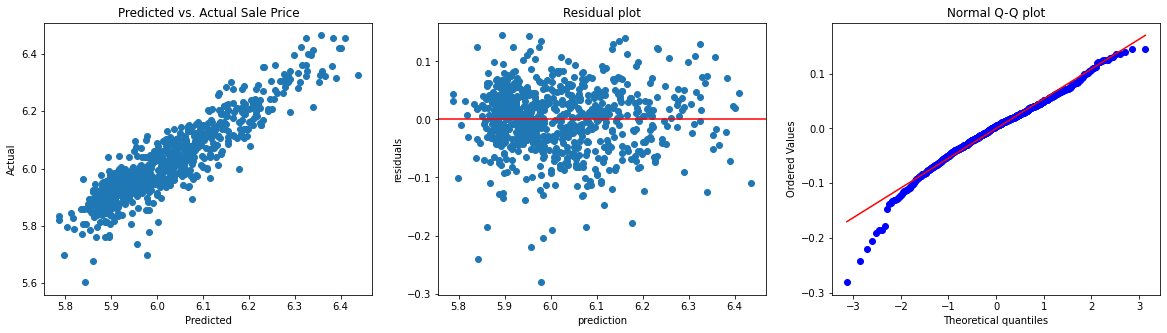

In [134]:
model_4.fit(X4_cv_scaled, y4_cv)

y4_pred = model_4.predict(X4_cv_scaled)

diagnostic_plots(X4_cv_scaled, y4_cv, y4_pred)

#### On a Mean MAE basis, this is on par w/ Model 2

### Model 5 - "Lazy" ElasticNet Regression (all the variables in the model)

In [135]:
X5 = df_data[df_data['sold_price'] <= 3e6].drop(columns='sold_price')
X5_cv, X5_test, y5_cv, y5_test = train_test_split(X5, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X5_cv_scaled = scaler.fit_transform(X5_cv)

In [136]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
l1_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]

elastic_model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, max_iter=1500000)

elastic_model.fit(X5_cv_scaled, y5_cv)

alpha = round(elastic_model.alpha_, 4)
print('Best alpha = {}'.format(alpha))
l1_ratio = round(elastic_model.l1_ratio_, 2)
print('Best L1 Ratio = {}'.format(l1_ratio))

Best alpha = 0.0001
Best L1 Ratio = 0.9


In [137]:
model_5 = ElasticNet(alpha=0.0001, l1_ratio=0.9, max_iter=1500000)

cv_rsquareds(X5_cv_scaled, y5_cv, model_5, 5)
cv_maes(X5_cv_scaled, y5_cv, model_5, 5)

CV R-squareds: [0.872, 0.821, 0.794, 0.795, 0.75]
Mean CV R-squared: 0.806 +/- 0.04

Adjusted CV R-squareds: [0.866, 0.813, 0.785, 0.786, 0.739]
Mean Adjusted CV R-squared: 0.798 +/- 0.042

CV MAEs: [0.04399956777315901, 0.04314211069361788, 0.04667582262881103, 0.0400352630014623, 0.04582332768174729]
Mean CV MAE: 0.0439352183557595 +/- 0.0023202879556265934


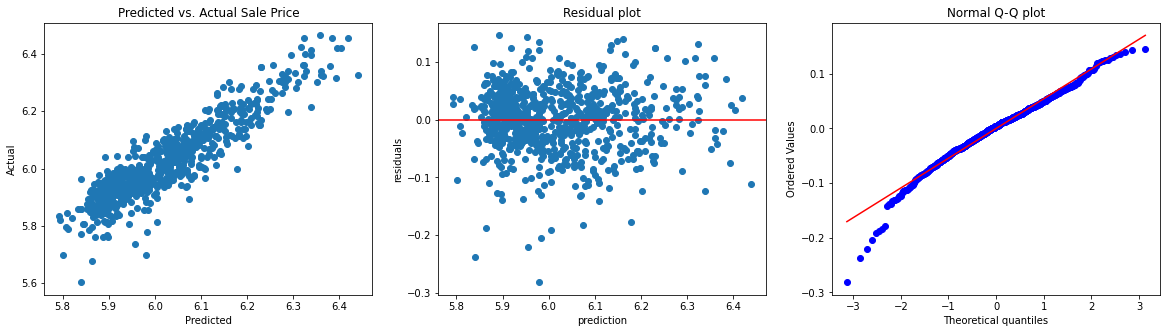

In [138]:
model_5.fit(X5_cv_scaled, y5_cv)

y5_pred = model_5.predict(X5_cv_scaled)

diagnostic_plots(X5_cv_scaled, y5_cv, y5_pred)

#### This looks like the best yet (on a Mean CV MAE basis)

In [139]:
list(zip(X5_cv.columns, model_5.coef_))

[('beds', 0.0065154664433259984),
 ('baths', 0.021569463538559694),
 ('hm_sqft', 0.08413678499416197),
 ('lot_size', 0.05929238568328982),
 ('yr_built', 0.002135525119829052),
 ('pool', -0.0031661609288009948),
 ('garage', 0.0032430395248078184),
 ('one_story', 0.005102011098086655),
 ('schools', -0.0),
 ('hoa', 0.0017509903543968764),
 ('zipcode_91303', -0.004039248516638649),
 ('zipcode_91304', -0.011250330258869873),
 ('zipcode_91306', -0.012238081577112486),
 ('zipcode_91307', -0.015345264726126323),
 ('zipcode_91311', -0.012623626409842027),
 ('zipcode_91316', 0.019797201913941923),
 ('zipcode_91324', -0.005121271109100593),
 ('zipcode_91325', -0.011545139966519744),
 ('zipcode_91326', -0.009321950213365411),
 ('zipcode_91335', -0.0055159650948877915),
 ('zipcode_91343', -0.017936830076788427),
 ('zipcode_91344', -0.017925790523143803),
 ('zipcode_91356', 0.008337668619358939),
 ('zipcode_91364', 0.002782990811383284),
 ('zipcode_91367', -0.0),
 ('zipcode_91406', -0.01139533420260

### Model 6: Random Forest Regression (all variables)

In [140]:
X6 = df_data[df_data['sold_price'] <= 3e6].drop(columns='sold_price')
X6_cv, X6_test, y6_cv, y6_test = train_test_split(X6, y, test_size=0.2, random_state=42)

In [141]:
grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]}

model_rf = RandomForestRegressor()

rf_gridsearch = RandomizedSearchCV(estimator = model_rf, 
                                   param_distributions = grid, 
                                   n_iter = 200, 
                                   cv = 5, 
                                   scoring = 'r2',
                                   verbose=0, 
                                   random_state=42, 
                                   n_jobs = -1)

rf_gridsearch.fit(X6_cv, y6_cv)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='r2')

In [142]:
rf_gridsearch.best_params_

{'n_estimators': 1200,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': False}

In [143]:
# Updated/narrowed-down grid based on the results found by randomized search above
grid = {'n_estimators': [1100, 1200, 1300],
        'max_features': ['sqrt'],
        'max_depth': [5, 10, 15],
        'min_samples_split': [3, 4, 5, 6, 7],
        'min_samples_leaf': [1, 2, 3],
        'bootstrap': [False]}

# Perform grid search
grid_search = GridSearchCV(estimator = RandomForestRegressor(), param_grid = grid, 
                          cv = 5, n_jobs = -1, verbose = 0)

grid_search.fit(X6_cv, y6_cv)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [5, 10, 15],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [3, 4, 5, 6, 7],
                         'n_estimators': [1100, 1200, 1300]})

In [144]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 1100}

In [145]:
model_6 = RandomForestRegressor(
    n_estimators=1100,
    min_samples_split=4,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=10,
    bootstrap=False
)

cv_rsquareds(X6_cv, y6_cv, model_6, 5)
cv_maes(X6_cv, y6_cv, model_6, 5)

CV R-squareds: [0.842, 0.792, 0.738, 0.713, 0.749]
Mean CV R-squared: 0.767 +/- 0.045

Adjusted CV R-squareds: [0.835, 0.783, 0.727, 0.701, 0.738]
Mean Adjusted CV R-squared: 0.757 +/- 0.047

CV MAEs: [0.045547107900016606, 0.04394153894735827, 0.052342441691942895, 0.04760291864677353, 0.0438131227308226]
Mean CV MAE: 0.04664942598338277 +/- 0.003159492035575382


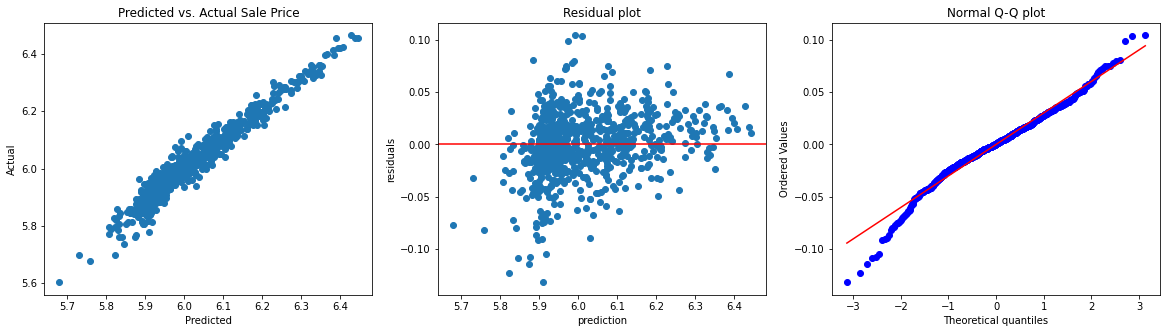

In [146]:
model_6.fit(X6_cv, y6_cv)

y6_pred = model_6.predict(X6_cv)

diagnostic_plots(X6_cv, y6_cv, y6_pred)

In [147]:
list(zip(X6_cv.columns, model_6.feature_importances_))

[('beds', 0.018582692453422534),
 ('baths', 0.08065271299038385),
 ('hm_sqft', 0.19005349680513778),
 ('lot_size', 0.10843379555979542),
 ('yr_built', 0.021342760878791795),
 ('pool', 0.0011264917242945044),
 ('garage', 0.0013976979970316012),
 ('one_story', 0.0064757477215465035),
 ('schools', 0.05119911057815273),
 ('hoa', 0.0006977069361962423),
 ('zipcode_91303', 0.0006124527902565457),
 ('zipcode_91304', 0.0016103246708219685),
 ('zipcode_91306', 0.0024914887870452302),
 ('zipcode_91307', 0.001966696063243577),
 ('zipcode_91311', 0.0013621589890423173),
 ('zipcode_91316', 0.013980317588661155),
 ('zipcode_91324', 0.0002475854970119181),
 ('zipcode_91325', 0.0023758848636627207),
 ('zipcode_91326', 0.0019220948044217196),
 ('zipcode_91335', 0.0010440510858553246),
 ('zipcode_91343', 0.0048425274480718775),
 ('zipcode_91344', 0.0032319517510572588),
 ('zipcode_91356', 0.0059004691780905295),
 ('zipcode_91364', 0.008607318651151781),
 ('zipcode_91367', 0.0055942236738613475),
 ('zipc